## 1️⃣ Importing Required Libraries and Modules
This section loads all dependencies, custom preprocessing and model scripts, and initializes SHAP for explainability.

In [1]:
import sys, os, warnings
warnings.filterwarnings("ignore")

# Put the repo root at the FRONT of sys.path so our local src wins
sys.path.insert(0, os.path.abspath(".."))   # <-- replace append(...) with insert(0, ...)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.preprocessing import load_raw, preprocess, split_xy
from src.model import train_xgb, evaluate, shap_summary

# add these imports
from src.model import compute_scale_pos_weight
from src.tune import tune_xgb

import shap
shap.initjs()


## 2️⃣ Loading the Telco Customer Churn Dataset
Reading the raw CSV file and running initial preprocessing to clean and prepare the data.

In [2]:
CSV_PATH = "../data/WA_Fn-UseC_-Telco-Customer-Churn.csv"

raw = load_raw(CSV_PATH)
df  = preprocess(raw)

print(df.shape)
df.head()


(7043, 31)


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,False,True,False,False,True,...,False,False,False,False,False,False,True,False,True,False
1,0,34,56.95,1889.50,0,True,False,False,True,False,...,False,False,False,False,True,False,False,False,False,True
2,0,2,53.85,108.15,1,True,False,False,True,False,...,False,False,False,False,False,False,True,False,False,True
3,0,45,42.30,1840.75,0,True,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
4,0,2,70.70,151.65,1,False,False,False,True,False,...,False,False,False,False,False,False,True,False,True,False


## 3️⃣ Splitting Data into Training and Test Sets
Separating features (X) and target (y) with an 80/20 split for model evaluation.

In [3]:
X_train, X_test, y_train, y_test = split_xy(df, target="Churn", test_size=0.2, seed=42)
X_train.shape, X_test.shape


((5634, 30), (1409, 30))

## 4️⃣ Hyperparameter Optimization with Optuna + XGBoost Model Training
Running Optuna to search the best hyperparameters, training the final tuned model, and evaluating performance on the test set.

[I 2025-08-01 23:59:29,571] A new study created in memory with name: xgb_churn
[I 2025-08-01 23:59:30,886] Trial 0 finished with value: 0.8466736812493677 and parameters: {'n_estimators': 414, 'max_depth': 6, 'learning_rate': 0.004020485444874823, 'subsample': 0.7364837774533047, 'colsample_bytree': 0.8872487642177366, 'reg_lambda': 0.1890164445525039, 'min_child_weight': 0.6723335646964915, 'gamma': 0.7902150286663284}. Best is trial 0 with value: 0.8466736812493677.
[I 2025-08-01 23:59:31,886] Trial 1 finished with value: 0.8486474663699264 and parameters: {'n_estimators': 545, 'max_depth': 4, 'learning_rate': 0.005897499112796209, 'subsample': 0.8241547407296153, 'colsample_bytree': 0.8787497713174331, 'reg_lambda': 0.15293229455024704, 'min_child_weight': 9.348233976568501, 'gamma': 2.0760203288800665}. Best is trial 1 with value: 0.8486474663699264.
[I 2025-08-01 23:59:32,600] Trial 2 finished with value: 0.8401804199043749 and parameters: {'n_estimators': 435, 'max_depth': 3, 'le

Best CV AUC: 0.8500574605966129
Best params: {'n_estimators': 609, 'max_depth': 3, 'learning_rate': 0.009190476960341325, 'subsample': 0.6376602172199095, 'colsample_bytree': 0.9157058441558541, 'reg_lambda': 1.1160230858310702, 'min_child_weight': 0.39793507568813447, 'gamma': 2.395972680684876}


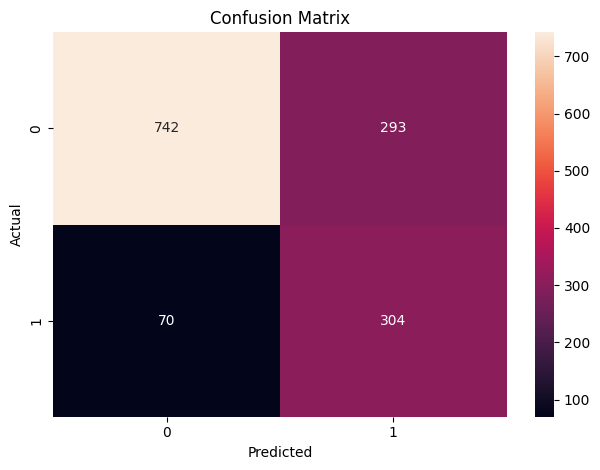

{'accuracy': 0.7423704755145494,
 'roc_auc': 0.8472603270557235,
 'precision_no': 0.9137931034482759,
 'recall_no': 0.7169082125603865,
 'precision_yes': 0.509212730318258,
 'recall_yes': 0.8128342245989305}

In [4]:
# Optuna tuning for XGBoost, then train the final model with best params
spw = compute_scale_pos_weight(y_train)  # imbalance handling

# Quick tuning (increase n_trials to 50–100 for better results)
study = tune_xgb(X_train, y_train, scale_pos_weight=spw, n_trials=30)
print("Best CV AUC:", study.best_value)
print("Best params:", study.best_params)

best_params = study.best_params
model = train_xgb(X_train, y_train, **best_params, scale_pos_weight=spw)

metrics = evaluate(model, X_test, y_test)
metrics


## 5️⃣ Explainable AI (SHAP Analysis)
Generating SHAP summary, dependence, and interaction plots to understand key churn drivers.

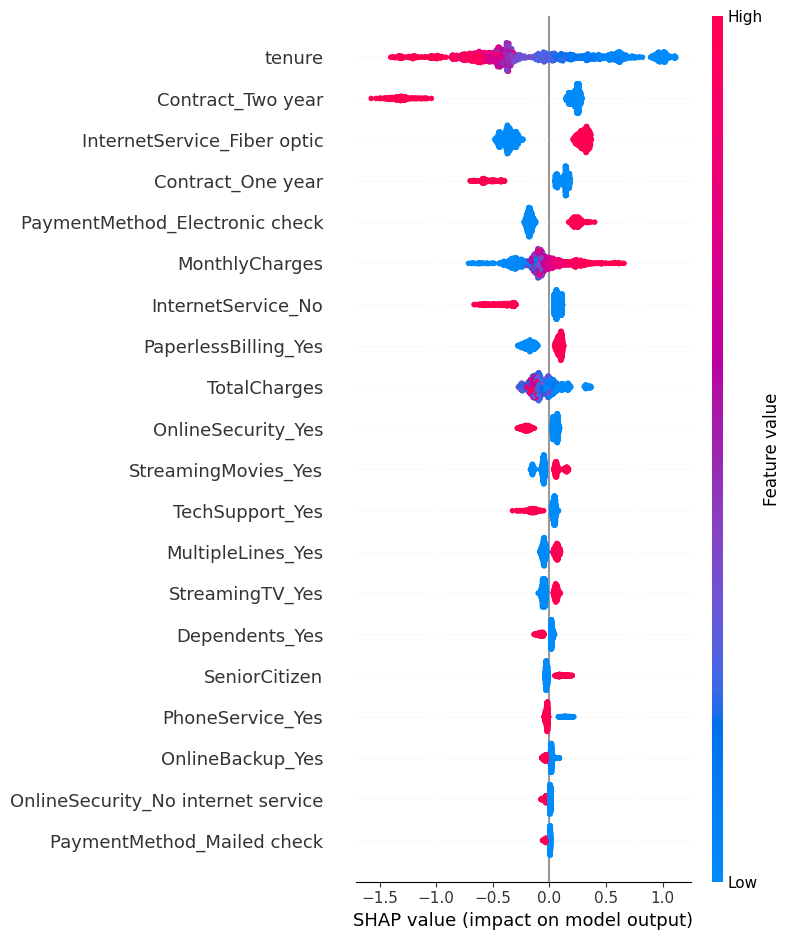

['tenure',
 'Contract_Two year',
 'InternetService_Fiber optic',
 'Contract_One year',
 'PaymentMethod_Electronic check']

In [5]:
import numpy as np
os.makedirs("../shap_outputs", exist_ok=True)

explainer = shap.TreeExplainer(model)
sv = explainer.shap_values(X_test)

# Global summary plot
shap.summary_plot(sv, X_test, show=False)
plt.tight_layout()
plt.savefig("../shap_outputs/shap_summary_plot.png", dpi=150, bbox_inches="tight")
plt.show()

# Identify top features by mean |SHAP|
mean_abs = np.abs(sv).mean(axis=0)
top_idx = np.argsort(mean_abs)[::-1][:5]
top_features = X_test.columns[top_idx].tolist()
top_features


## 6️⃣ Saving Trained Model and Features for Deployment
Exporting the XGBoost model and feature list as artifacts for use in the Streamlit app.

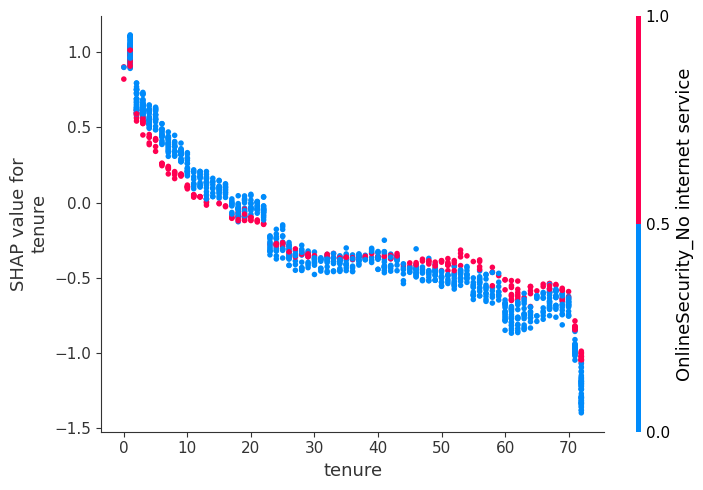

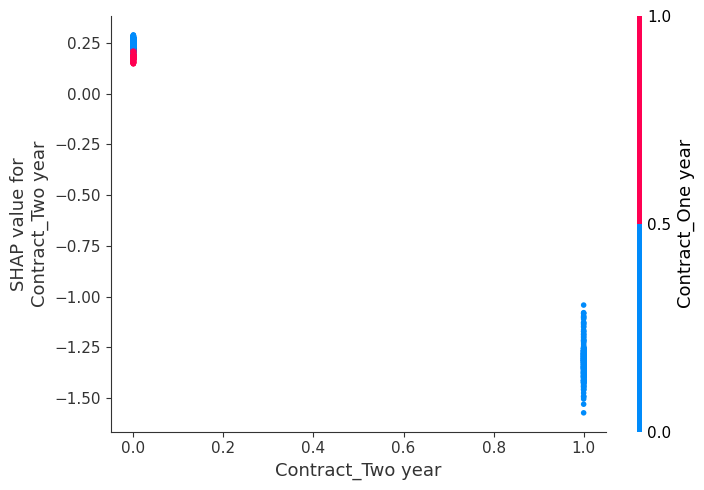

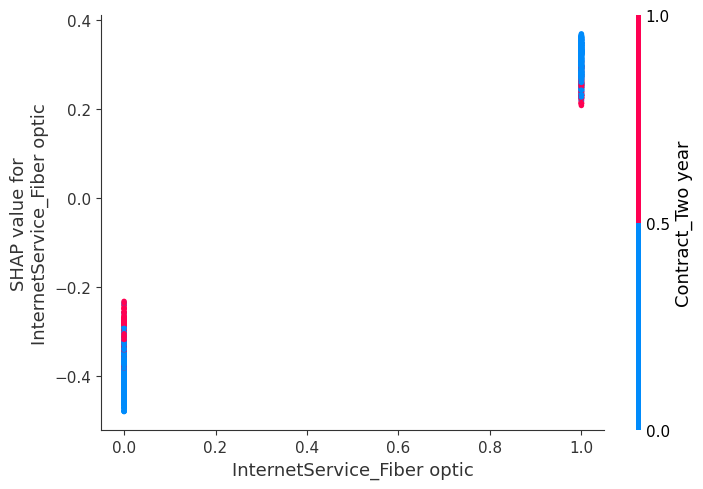

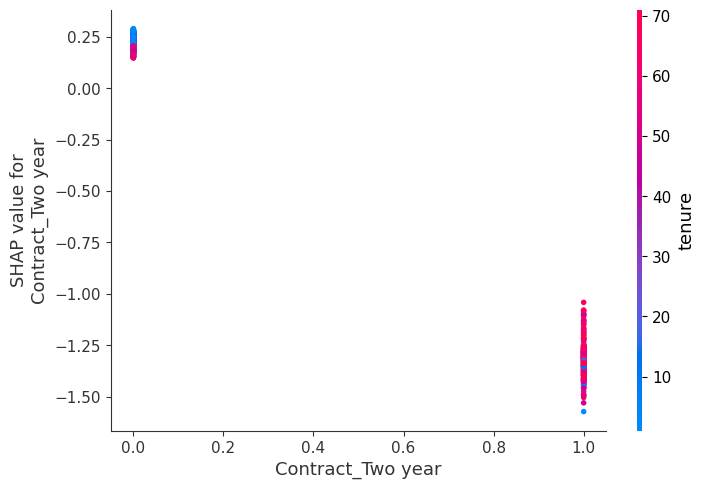

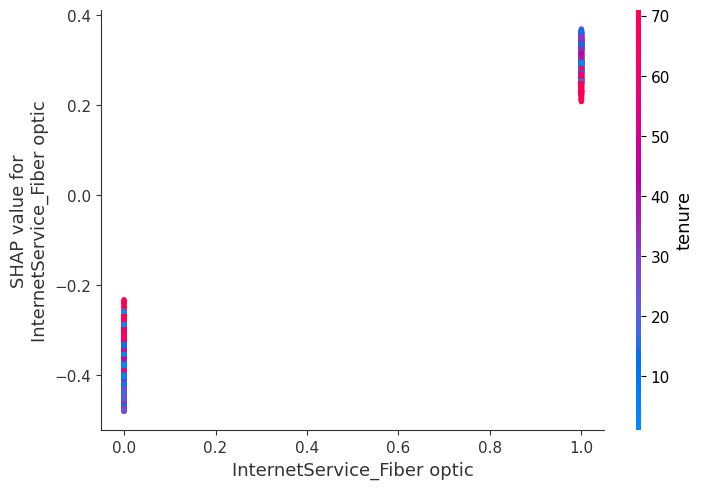

In [6]:
# Dependence plots for top 3 features
for f in top_features[:3]:
    shap.dependence_plot(f, sv, X_test, show=False)
    plt.tight_layout()
    plt.savefig(f"../shap_outputs/dependence_{f}.png", dpi=150, bbox_inches="tight")
    plt.show()

# Interaction plots: pair top 2 with the top-most feature
for f in top_features[1:3]:
    shap.dependence_plot(f, sv, X_test, interaction_index=top_features[0], show=False)
    plt.tight_layout()
    plt.savefig(f"../shap_outputs/interaction_{f}_with_{top_features[0]}.png", dpi=150, bbox_inches="tight")
    plt.show()


In [7]:
import json, joblib
os.makedirs("../artifacts", exist_ok=True)
joblib.dump(model, "../artifacts/model_xgb.pkl")
with open("../artifacts/feature_list.json", "w") as f:
    json.dump(list(X_train.columns), f)

"Artifacts saved to ../artifacts/"


'Artifacts saved to ../artifacts/'